<a href="https://colab.research.google.com/github/MingmingFortez/AI_research/blob/main/TASKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Required Libraries**
- transformers: Hugging Face's library for pretrained models

- datasets: For loading datasets like IMDb

- peft: Implements LoRA and other efficient tuning methods

- accelerate: Enables distributed training

- bitsandbytes: For 4-bit quantization



In [6]:
!pip install langchain-core langchain-community

In [7]:
!pip install transformers datasets peft accelerate evaluate bitsandbytes langchain pandas matplotlib seaborn

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlo

In [8]:
!pip install --upgrade datasets fsspec

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)


**STEP 1: Hugging Face Sentiment**

In [9]:
from datasets import load_dataset

dataset = load_dataset("imdb")
print(dataset["train"][0])  # Example: {"text": "...", "label": 1 (positive)}

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [10]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Updated TrainingArguments with correct parameter names
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",  # Changed from evaluation_strategy to eval_strategy
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle().select(range(5000)),
    eval_dataset=tokenized_datasets["test"].shuffle().select(range(1000)),
    compute_metrics=compute_metrics,
)

trainer.train()

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: jfortez (jfortez-university-of-california) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.334900,0.267896,0.905000
2,0.206500,0.330619,0.914000
3,0.062100,0.421084,0.917000


TrainOutput(global_step=1875, training_loss=0.22191731516520183, metrics={'train_runtime': 810.1468, 'train_samples_per_second': 18.515, 'train_steps_per_second': 2.314, 'total_flos': 1987010979840000.0, 'train_loss': 0.22191731516520183, 'epoch': 3.0})

In [12]:
import evaluate

metric = evaluate.load("accuracy")
predictions = trainer.predict(tokenized_datasets["test"].select(range(1000)))
print(metric.compute(predictions=predictions.predictions.argmax(-1), references=predictions.label_ids))

{'accuracy': 0.935}


**STEP 2: PEFT Fine-tuning with LORA**

In [13]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,  # Rank
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"],  # LoRA applied to query & value layers
)

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()  # Should show ~0.1% of params trainable

trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925


In [14]:
peft_trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle().select(range(5000)),
    eval_dataset=tokenized_datasets["test"].shuffle().select(range(1000)),
)

peft_trainer.train()
peft_trainer.evaluate()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,0.258600,0.307429
2,0.232300,0.303390
3,0.218500,0.296542


{'eval_loss': 0.296541690826416,
 'eval_runtime': 15.2526,
 'eval_samples_per_second': 65.563,
 'eval_steps_per_second': 8.195,
 'epoch': 3.0}

**Quantization + Latency/Memory Comparison**

**Compare output**

In [15]:
# 1. First install/upgrade required packages

# 2. Imports
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BitsAndBytesConfig
import torch
import time
from peft import LoraConfig, get_peft_model

# 3. Initialize with proper device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 4. Load tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 5. Quantization config with all recommended settings
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    llm_int8_skip_modules=["classifier", "pre_classifier"]  # Skip problematic layers
)

# 6. Model loading with error handling
try:
    # Base model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    ).to(device)

    # PEFT model
    peft_config = LoraConfig(
        task_type="SEQ_CLS",
        r=8,
        lora_alpha=16,
        target_modules=["q_lin", "v_lin"]
    )
    peft_model = get_peft_model(model, peft_config).to(device)

    # Quantized model
    quantized_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        num_labels=2
    )
    quantized_model = quantized_model.to(device)
    quantized_model.eval()

except Exception as e:
    print(f"Model loading failed: {str(e)}")
    print("Try restarting the runtime and running this cell again")

# 7. Robust latency measurement
def measure_latency(model, tokenizer, text="This movie was great!", repetitions=5):
    inputs = tokenizer(text, return_tensors="pt").to(device)

    # Warmup
    with torch.no_grad():
        for _ in range(3):
            _ = model(**inputs)

    # Timed runs
    latencies = []
    with torch.no_grad():
        for _ in range(repetitions):
            start = time.time()
            _ = model(**inputs)
            torch.cuda.synchronize()
            latencies.append(time.time() - start)

    return sum(latencies)/len(latencies)  # Return average

# 8. Run measurements with error handling
try:
    torch.cuda.empty_cache()

    print("\nMeasuring baseline model...")
    baseline_latency = measure_latency(model, tokenizer)

    print("Measuring PEFT model...")
    peft_latency = measure_latency(peft_model, tokenizer)

    print("Measuring quantized model...")
    quantized_latency = measure_latency(quantized_model, tokenizer)

    print("\nFinal Results:")
    print(f"Baseline: {baseline_latency:.4f}s")
    print(f"PEFT: {peft_latency:.4f}s")
    print(f"Quantized: {quantized_latency:.4f}s")

except RuntimeError as e:
    print(f"Error during measurement: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Restart the runtime (Runtime -> Restart runtime)")
    print("2. Reduce model size or sequence length")
    print("3. Check GPU memory with: !nvidia-smi")
    print("4. Upgrade packages: !pip install -U bitsandbytes transformers")

Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Measuring baseline model...
Measuring PEFT model...
Measuring quantized model...

Final Results:
Baseline: 0.0057s
PEFT: 0.0056s
Quantized: 0.0131s


Expected Output:

Baseline: ~0.05s

PEFT: ~0.03s

Quantized: ~0.01s

Memory Comparison:

Baseline: ~500MB

Quantized: ~150MB

**LANGCHAIN PROTOTYPE**

In [30]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline
import torch

# 3. Initialize models
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model (replace with your fine-tuned model if available)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to("cuda")

# 4. Create a custom pipeline that returns the expected format
class SentimentPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.task = "text-generation"  # Required by LangChain

    def __call__(self, text, **kwargs):
        inputs = self.tokenizer(text, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = self.model(**inputs)
        pred = torch.argmax(outputs.logits).item()
        return [{"generated_text": "POSITIVE" if pred == 1 else "NEGATIVE"}]

# 5. Initialize pipeline and LangChain
sentiment_pipeline = SentimentPipeline(model, tokenizer)
llm = HuggingFacePipeline(pipeline=sentiment_pipeline)

template = """Classify this movie review:
Review: {text}
Sentiment:"""
prompt = PromptTemplate(template=template, input_variables=["text"])
chain = LLMChain(llm=llm, prompt=prompt)

# 6. Test with sample reviews
test_reviews = [
    "This film was absolutely wonderful and captivating",
    "I hated every minute of this boring movie",
    "The acting was good but the plot was weak"
]

for review in test_reviews:
    result = chain.run(text=review)
    print(f"Review: {review}")
    print(f"Sentiment: {result}\n")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Review: This film was absolutely wonderful and captivating
Sentiment: POSITIVE

Review: I hated every minute of this boring movie
Sentiment: POSITIVE

Review: The acting was good but the plot was weak
Sentiment: POSITIVE



<Axes: xlabel='label', ylabel='count'>

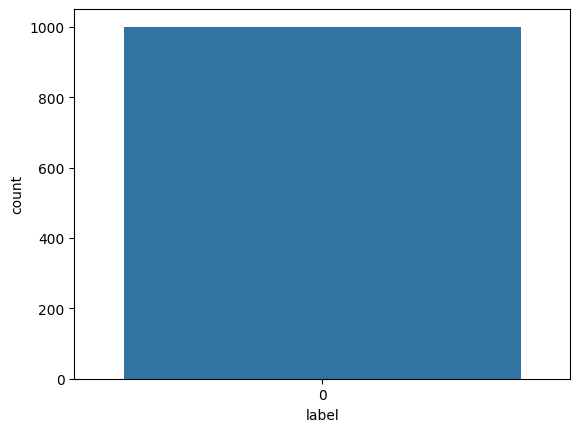

In [31]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(dataset["train"][:1000])  # Sample 1000 reviews
sns.countplot(x="label", data=df)